
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       29
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equa

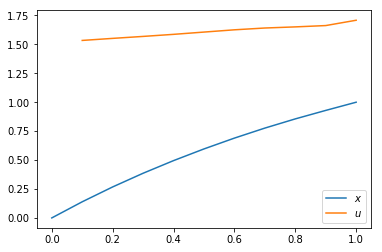

In [1]:
%matplotlib inline
from pymoca.backends.casadi.api import transfer_model
import numpy as np
import casadi as ca
from pylab import plot, hold, legend

model = transfer_model('../models/', 'Exponential', {})
dae = model.dae_residual_function
X0 = model.states[0].start

# Discretization steps
N = 10

# Discretization time step
dt = 0.1

# Optimization variables and bounds
X = ca.MX.sym('X', N)
lbX = np.full(N, -np.inf)
ubX = np.full(N, np.inf)

U = ca.MX.sym('U', N)
lbU = np.full(N, 0)
ubU = np.full(N, 1.75)

# Collocate DAE using backwards Euler method
g = []
i = 0
res = dae(0, X[0], (X[0] - X0) / dt, U[0], U[i], ca.MX(), ca.MX())
g.append(res)
for i in range(1, N):
    res = dae(i * dt, X[i], (X[i] - X[i - 1]) / dt, ca.MX(), U[i], ca.MX(), ca.MX())
    g.append(res)
    
# Optimization objective
f = (X[-1] - 1.0)**2

# Solve NLP
nlp = {'x': ca.vertcat(X, U), 'f': f, 'g': ca.vertcat(*g)}
ipopt_options = {'tol': 1e-6}
solver = ca.nlpsol('nlp', 'ipopt', nlp, {'ipopt': ipopt_options})
solution = solver(lbx=ca.vertcat(lbX, lbU), ubx=ca.vertcat(ubX, ubU), lbg=0, ubg=0)

# Plot solution
T = np.linspace(0, N * dt, N + 1)
X = solution['x'][0:N]
U = solution['x'][N:2*N]
plot(T, ca.vertcat(X0, X), label="$x$")
plot(T[1:], U, label="$u$")
legend()